In [ ]:
'''
File for the pipeline
Text Processing -> Tfidf + clip embeddings -> lightgbm
'''
import gc
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix
import re
from sklearn.decomposition import PCA
import joblib

# Import NLTK for text processing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# --- One-time NLTK downloads ---
# The first time you run this, you may need to download the NLTK data.
# You can uncomment the following lines to do so.

# nltk.data.find('tokenizers/punkt')
# nltk.data.find('corpora/wordnet')
# nltk.data.find('corpora/stopwords')

print("Downloading NLTK data...")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
print("Downloads complete.")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

Downloads complete.


[nltk_data] Downloading package punkt to C:\Users\DCL
[nltk_data]     USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\DCL
[nltk_data]     USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\DCL
[nltk_data]     USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\DCL
[nltk_data]     USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def preprocess_text(text):
    """
    Cleans, tokenizes, removes stopwords, and lemmatizes the input text.
    """
    if not isinstance(text, str):
        text = ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text) # Tokenize the text

    # Lemmatize and remove stopwords
    lemmatized_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words
    ]

    return ' '.join(lemmatized_tokens)

In [4]:
print("Loading data...")
train_df = pd.read_csv('student_resource/dataset/df_train_pavan.csv')
test_df = pd.read_csv('student_resource/dataset/df_test_pavan.csv')

print("Preprocessing text data with lemmatization...")
train_df['clean_description'] = train_df['description'].apply(preprocess_text)
test_df['clean_description'] = test_df['description'].apply(preprocess_text)

Loading data...
Preprocessing text data with lemmatization...


In [5]:
print("Applying TF-IDF Vectorizer...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    # Stop words are now handled in our preprocess_text function
)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_description']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_df['clean_description']).toarray()

Applying TF-IDF Vectorizer...


In [6]:
print("Processing numerical features...")
# Fill missing values. Using the median is robust to outliers.
median_value = train_df['value'].median()
train_df['value'].fillna(median_value, inplace=True)
test_df['value'].fillna(median_value, inplace=True)
# Reshape for stacking
X_train_value = train_df[['value']].values
X_test_value = test_df[['value']].values

print("Processing categorical features with One-Hot Encoding...")
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_unit = ohe.fit_transform(train_df[['unit']])
X_test_unit = ohe.transform(test_df[['unit']])

Processing numerical features...
Processing categorical features with One-Hot Encoding...


C:\Users\DCL USER\AppData\Local\Temp\ipykernel_10640\942384351.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['value'].fillna(median_value, inplace=True)
C:\Users\DCL USER\AppData\Local\Temp\ipykernel_10640\942384351.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [7]:
X_train_clip = pd.read_csv('train_clip_embed.csv').drop('prices', axis=1).values
X_test_clip = pd.read_csv('test_clip_embed.csv').drop('prices', axis=1).values

pca = PCA(500)
X_train_clip =  pca.fit_transform(X_train_clip)
X_test_clip =  pca.transform(X_test_clip)

In [11]:
# --- Combine all features ---
print("Combining all features into a single matrix...")
X_train_combined = np.concatenate([X_train_tfidf, X_train_value, X_train_unit, X_train_clip], axis=1)
X_test_combined = np.concatenate([X_test_tfidf, X_test_value, X_test_unit, X_test_clip], axis=1)

# Target variable
y_train_log = np.log1p(train_df['price'])

Combining all features into a single matrix...


In [12]:
del train_df, test_df, X_train_value, X_train_unit, X_train_tfidf, X_train_clip
del X_test_value, X_test_unit, X_test_tfidf, X_test_clip
gc.collect()

474

In [13]:
# --- Model Training ---
print("Training LightGBM model on combined features...")
lgbm = lgb.LGBMRegressor(
    objective='regression_l1',
    metric='rmse',
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    device_type='gpu'
    )
lgbm.fit(X_train_combined, y_train_log)

Training LightGBM model on combined features...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 380748
[LightGBM] [Info] Number of data points in the train set: 73499, number of used features: 1508
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 511 dense feature groups (35.89 MB) transferred to GPU in 0.020491 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.704711


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.01
,n_estimators,2000
,subsample_for_bin,200000
,objective,'regression_l1'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [14]:
print("Generating predictions...")
log_predictions = lgbm.predict(X_test_combined)
predictions = np.expm1(log_predictions)

Generating predictions...


C:\Users\DCL USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

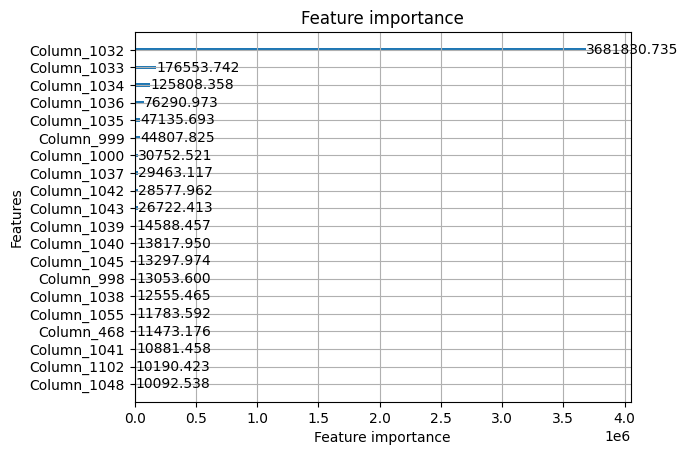

In [15]:
lgb.plot_importance(lgbm, importance_type='gain', max_num_features=20)

(array([29301., 22825., 10862.,  5405.,  2481.,  1594.,   992.,   749.,
          593.,   198.]),
 array([ 1.27214768, 11.03123825, 20.79032883, 30.5494194 , 40.30850998,
        50.06760055, 59.82669113, 69.5857817 , 79.34487228, 89.10396285,
        98.86305343]),
 <BarContainer object of 10 artists>)

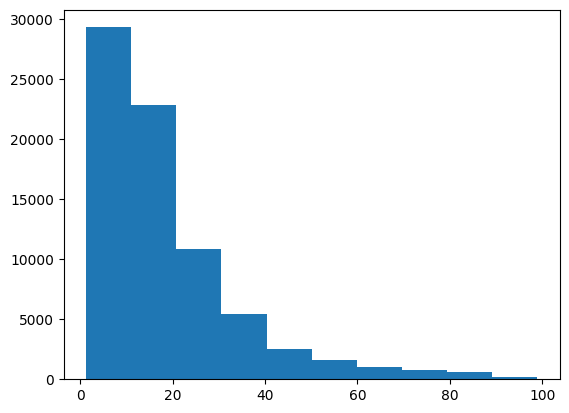

In [16]:
plt.hist(predictions)

In [18]:
print("Creating submission file...")
test_df = pd.read_csv('student_resource/dataset/df_test_pavan.csv')
submission_df = pd.DataFrame({'sample_id': test_df['sample_id'], 'price': predictions})
submission_df.to_csv('mid.csv', index=False)

Creating submission file...


In [15]:
submission_df

,sample_id,price
0,100179,13.971277
1,245611,14.757371
2,146263,24.726126
3,95658,13.448252
4,36806,33.130265
...,...,...
74995,93616,8.251234
74996,249434,22.385687
74997,162217,6.552347
74998,230487,14.129009
